In [29]:
import os
import sys
import pandas as pd
import argparse
import warnings
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import *
from torch import nn
import copy
from tqdm import tqdm
import random 
import numpy as np
from scipy import stats
from train import train_parameter, test_parameter, train_non_parameter, test_non_parameter
from model_non_parameter import ANN_gaussian, ANN_quantile,DRO_layer_dynamic_price,Intra_schdule_layer,Determinisitic_layer
from model_non_parameter import Combined_model_non_parameter_dynamic_price,Combined_deterministic_non_parameter_dynamic_price
from optimization import SO_cvxpy_parameter,DRO_cvxpy_non_parameter
from test_non_parameter import Evaluation_deterministic_non_parameter,Evaluation_original_model_non_parameter
from online_non_parameter import *
warnings.filterwarnings("ignore")
#torch.set_default_dtype(torch.float64)

In [30]:
set_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [31]:
parser_train = argparse.ArgumentParser()
parser_train.add_argument('--seq_len', type=int, default=24*7)
parser_train.add_argument('--pred_len', type=int, default=24)
parser_train.add_argument('--label_len', type=int, default=0)
parser_train.add_argument('--train_length', type=int, default=17376)
parser_train.add_argument('--target', type=str, default='target')
parser_train.add_argument('--scale', type=bool, default=True)
parser_train.add_argument('--inverse', type=bool, default=True)
parser_train.add_argument('--num_epochs', type=int, default=1000)
parser_train.add_argument('--mode', type=str, default='no-parameter')
parser_train.add_argument('--quantiles', type=list, default=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95])
parser_train.add_argument('--lr', type=float, default=5e-3)
parser_train.add_argument('--patience', type=int, default=20)
parser_train.add_argument('--hidden_layers', type=list, default=[128,128,128])
parser_train.add_argument('--e2e_num_epochs', type=int, default=5)
parser_train.add_argument('--e2e_lr', type=float, default=1e-5)
parser_train.add_argument('--e2e_ft_lr', type=float, default=1e-6)
parser_train.add_argument('--ft_lr', type=int, default=1e-3)
parser_train.add_argument('--batch_size', type=int, default=16)
parser_train.add_argument('--device', type=str, default='cuda:0' if torch.cuda.is_available() else 'cpu')
parser_train.add_argument('--epsion_p', type=float, default=1e1)
parser_train.add_argument('--epsion_l', type=float, default=1e1)
parser_train.add_argument('--metric_list', type=list, default=['pinball_loss','winkler_score_0.1','MAE','RMSE'])

parser_train.add_argument('--T', type=int, default=24)
parser_train.add_argument('--N', type=int, default=25)
parser_train.add_argument('--N_g', type=int, default=3)
parser_train.add_argument('--x_max', type=int, default=3000)
parser_train.add_argument('--x_min', type=int, default=0)
parser_train.add_argument('--z_pos_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_neg_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_pos_min', type=int, default=0)
parser_train.add_argument('--z_neg_min', type=int, default=0)
parser_train.add_argument('--r_neg', type=int, default=1000)
parser_train.add_argument('--r_pos', type=int, default=1000)
parser_train.add_argument('--alpha', type=list, default=[0.03 for i in range(24)]+[0.028 for i in range(24)]+[0.032 for i in range(24)])
parser_train.add_argument('--alpha_pos', type=list, default=[0.02 for i in range(24)]+[0.018 for i in range(24)]+[0.022 for i in range(24)])
parser_train.add_argument('--alpha_neg', type=list, default=[0.01 for i in range(24)]+[0.009 for i in range(24)]+[0.011 for i in range(24)])

parser_train.add_argument('--rho_z_pos', type=list, default=[0.05 for i in range(24)]+[0.045 for i in range(24)]+[0.055 for i in range(24)])
parser_train.add_argument('--rho_z_neg', type=list, default=[0.01 for i in range(24)]+[0.008 for i in range(24)]+[0.012 for i in range(24)])

parser_train.add_argument('--rho_r_pos', type=list, default=[0.1 for i in range(24)])
parser_train.add_argument('--rho_r_neg', type=list, default=[0.05 for i in range(24)])

# True+1：（e2e ft lr：1e-5），（e2e ft: 1e-6）
# True+2: （e2e ft lr：1e-6），（e2e ft: 1e-5）
parser_train.add_argument('--time_flag', type=bool, default=True)
parser_train.add_argument('--price_ratio_large', type=float, default=4)
parser_train.add_argument('--price_ratio_small', type=float, default=0.8)
parser_train.add_argument('--flag_dynamic_price', type=bool, default=True)
parser_train.add_argument('--flag_dynamic_mode', type=int, default=2)
parser_train.add_argument('--upper_quantiles', type=float, default=0.95)
parser_train.add_argument('--lower_quantiles', type=float, default=0.05)
parser_train.add_argument('--epsion', type=float, default=1)

args_train = parser_train.parse_args(args=[])

In [32]:
train_load_data,train_load_loader=get_load_data(args_train,flag='train')
val_load_data,val_load_loader=get_load_data(args_train,flag='val')
test_load_data,test_load_loader=get_load_data(args_train,flag='test')

train_pv_data,train_pv_loader=get_pv_data(args_train,flag='train')
val_pv_data,val_pv_loader=get_pv_data(args_train,flag='val')
test_pv_data,test_pv_loader=get_pv_data(args_train,flag='test')

combined_train_data,combined_train_loader,combined_val_data,combined_val_loader,combined_test_data,combined_test_loader,combined_fine_tune_data,combined_fine_tune_loader = obtain_price(args_train,train_pv_data,train_load_data,val_pv_data,val_load_data,test_pv_data,test_load_data)


../Data/GEF_data/data.csv
(143, 24, 11)
(143, 24)
../Data/GEF_data/data.csv
(36, 24, 11)
(36, 24)
../Data/GEF_data/data.csv
(544, 24, 11)
(544, 24)
../Data/PV/PV_1h.csv
(143, 13, 11)
(143, 13)
../Data/PV/PV_1h.csv
(36, 13, 11)
(36, 13)
../Data/PV/PV_1h.csv
(544, 13, 11)
(544, 13)
Test data is not shuffled
Test data is not shuffled


### load forecasting

In [33]:
input_size=train_load_data.X.shape[-1]
output_size=len(args_train.quantiles)
set_seed(42)
model_load=ANN_quantile(input_size=input_size, hidden_layers=args_train.hidden_layers, quantiles=args_train.quantiles).to(device)
train_non_parameter(args_train, model_load, train_load_loader, val_load_loader,dir_best_model='../Model/best_ann_load.pt')

Epoch 0, Train Loss: 0.2653690092265606
Epoch [1/1000] Train Loss: 0.2654 Val Loss: 0.1465
Epoch [2/1000] Train Loss: 0.1326 Val Loss: 0.1187
Epoch [3/1000] Train Loss: 0.0990 Val Loss: 0.0975
Epoch [4/1000] Train Loss: 0.0943 Val Loss: 0.0924
Epoch [5/1000] Train Loss: 0.0874 Val Loss: 0.1060
Epoch [6/1000] Train Loss: 0.0841 Val Loss: 0.0833
Epoch [7/1000] Train Loss: 0.0727 Val Loss: 0.0814
Epoch [8/1000] Train Loss: 0.0692 Val Loss: 0.0784
Epoch [9/1000] Train Loss: 0.0652 Val Loss: 0.0759
Epoch [10/1000] Train Loss: 0.0648 Val Loss: 0.0818
Epoch 10, Train Loss: 0.06325957458466291
Epoch [11/1000] Train Loss: 0.0633 Val Loss: 0.0827
Epoch [12/1000] Train Loss: 0.0651 Val Loss: 0.0793
Epoch [13/1000] Train Loss: 0.0585 Val Loss: 0.0750
Epoch [14/1000] Train Loss: 0.0583 Val Loss: 0.0770
Epoch [15/1000] Train Loss: 0.0568 Val Loss: 0.0752
Epoch [16/1000] Train Loss: 0.0591 Val Loss: 0.0812
Epoch [17/1000] Train Loss: 0.0598 Val Loss: 0.0778
Epoch [18/1000] Train Loss: 0.0607 Val Loss

### pv forecasting

In [34]:
input_size=train_pv_data.X.shape[-1]#pv_flag=False,threshold=10,scaler_y=train_pv_data.scaler_y
model_pv=ANN_quantile(input_size=input_size, hidden_layers=args_train.hidden_layers, quantiles=args_train.quantiles,pv_flag=True,threshold=10,scaler_y=train_pv_data.scaler_y).to(device)
train_non_parameter(args_train, model_pv, train_pv_loader, val_pv_loader,dir_best_model='../Model/best_ann_pv.pt')

Epoch 0, Train Loss: 0.30013379640877247
Epoch [1/1000] Train Loss: 0.3001 Val Loss: 0.1628
Epoch [2/1000] Train Loss: 0.1665 Val Loss: 0.1254
Epoch [3/1000] Train Loss: 0.1357 Val Loss: 0.1251
Epoch [4/1000] Train Loss: 0.1275 Val Loss: 0.1116


Epoch [5/1000] Train Loss: 0.1160 Val Loss: 0.1160
Epoch [6/1000] Train Loss: 0.1136 Val Loss: 0.1053
Epoch [7/1000] Train Loss: 0.1062 Val Loss: 0.1087
Epoch [8/1000] Train Loss: 0.1055 Val Loss: 0.1067
Epoch [9/1000] Train Loss: 0.1027 Val Loss: 0.1085
Epoch [10/1000] Train Loss: 0.1044 Val Loss: 0.1041
Epoch 10, Train Loss: 0.10233965702354908
Epoch [11/1000] Train Loss: 0.1023 Val Loss: 0.1007
Epoch [12/1000] Train Loss: 0.1000 Val Loss: 0.1023
Epoch [13/1000] Train Loss: 0.0987 Val Loss: 0.1078
Epoch [14/1000] Train Loss: 0.0984 Val Loss: 0.1022
Epoch [15/1000] Train Loss: 0.0934 Val Loss: 0.1005
Epoch [16/1000] Train Loss: 0.0941 Val Loss: 0.0985
Epoch [17/1000] Train Loss: 0.0900 Val Loss: 0.0992
Epoch [18/1000] Train Loss: 0.0893 Val Loss: 0.0978
Epoch [19/1000] Train Loss: 0.0868 Val Loss: 0.1040
Epoch [20/1000] Train Loss: 0.0912 Val Loss: 0.0962
Epoch 20, Train Loss: 0.08637932874262333
Epoch [21/1000] Train Loss: 0.0864 Val Loss: 0.1026
Epoch [22/1000] Train Loss: 0.0927 Va

In [35]:
determinisitic_opt_layer = Determinisitic_layer(args_train)
intra_opt_layer = Intra_schdule_layer(args_train)
dro_opt_layer = DRO_layer_dynamic_price(args_train)

In [36]:
model_org_deterministic =  Combined_deterministic_non_parameter_dynamic_price(determinisitic_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load)).to(device)
model_org_dro =  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load)).to(device)

In [37]:
with torch.no_grad():
    solution_list_org_ahead_deterministic, solution_list_org_intra_deterministic, cost_org_deterministic =Evaluation_original_model_non_parameter(args_train, model_org_deterministic, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y)

In [38]:
with torch.no_grad():
    solution_list_org_ahead_ideal, solution_list_org_intra_ideal, cost_org_ideal =Evaluation_original_model_non_parameter(args_train, model_org_deterministic, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y,mode='ideal')

In [39]:

# with open(output_file, 'w') as f:
#     sys.stdout = f
Cost_with_N_org=[]
args_train_for_change = copy.deepcopy(args_train)
for N in [25,50,75,100,125]:
#for N in [10]:
    print('============================================================')
    print('epsion:',N)
    print('============================================================')
    args_train_for_change.N=N
    determinisitic_opt_layer = Determinisitic_layer(args_train_for_change)
    intra_opt_layer = Intra_schdule_layer(args_train_for_change)
    dro_opt_layer = DRO_layer_dynamic_price(args_train_for_change)

    model_org_dro=  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
    with torch.no_grad():
        solution_list_org_intra_dro, solution_list_org_ahead_dro, cost_org_dro, forecasts_pv_org, forecasts_load_org,targets_pv,targets_load=Evaluation_original_model_non_parameter(args_train_for_change, model_org_dro, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y,mode='dro')
    Cost_with_N_org.append(np.mean(copy.deepcopy(cost_org_dro)))

pd.DataFrame(Cost_with_N_org).to_csv('../Result/Different N/Non parameter/Cost_org_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)

epsion: 25
--------------PV--------------
Pinball Loss: 48.64499088557934
Winkler Score_0.1: 727.1666915147538
MAE: 126.77077400009632
RMSE: 247.43585484978834
--------------Load--------------
Pinball Loss: 88.74879125354754
Winkler Score_0.1: 1975.1333206803663
MAE: 228.89960058104793
RMSE: 295.34159001259064
--------------PV--------------
Pinball Loss: 45.00709781675071
Winkler Score_0.1: 687.8152537917758
MAE: 117.90819297427004
RMSE: 218.58599147109558
--------------Load--------------
Pinball Loss: 71.93364135055104
Winkler Score_0.1: 1449.3893135004294
MAE: 173.98050508862443
RMSE: 209.94131579063242
--------------PV--------------
Pinball Loss: 43.75547477509531
Winkler Score_0.1: 735.1784810948762
MAE: 109.69079809445321
RMSE: 207.12298666188613
--------------Load--------------
Pinball Loss: 52.415834380437175
Winkler Score_0.1: 1056.0147481585318
MAE: 130.46710206406476
RMSE: 163.419462963863
--------------PV--------------
Pinball Loss: 53.58309916536819
Winkler Score_0.1: 788.2

In [40]:
# output_file='../Result/Log/Different N/Non parameter/Cost_with_N.txt'
# with open(output_file, 'w') as f:
#     sys.stdout = f
Cost_with_N=[]
time_with_N=[]
args_train_for_change = copy.deepcopy(args_train)
for N in [25,50,75,100,125]:
#for N in [10]:
    print('============================================================')
    print('epsion:',N)
    print('============================================================')
    args_train_for_change.N=N
    determinisitic_opt_layer = Determinisitic_layer(args_train_for_change)
    intra_opt_layer = Intra_schdule_layer(args_train_for_change)
    dro_opt_layer = DRO_layer_dynamic_price(args_train_for_change)
    
    combined_model =  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
    combined_model.to(device)
    set_seed(42)
    solution_list_ahead, solution_list_intra, cost_list, forecasts_pv,forecasts_load,time_list= Traditional_online_non_parameter(args_train_for_change, combined_model, combined_fine_tune_loader, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y,time_flag=args_train.time_flag)
    time_with_N.append(time_list)
    Cost_with_N.append(np.mean(cost_list))

pd.DataFrame(Cost_with_N).to_csv('../Result/Different N/Non parameter/Cost_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)

epsion: 25
New test batch 1
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 48.636334908308555
Winkler Score_0.1: 727.1400110947254
MAE: 126.75567736946769
RMSE: 247.40332426362053
--------------Load--------------
Pinball Loss: 88.32016600859548
Winkler Score_0.1: 1956.4426672783823
MAE: 228.06373588138715
RMSE: 294.02566628780244
Test Objective: 3645.152475791244
New test batch 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 44.9857732270933
Winkler Score_0.1: 687.6362251687808
MAE: 117.82813057389765
RMSE: 218.51877673324068
--------------Load--------------
Pinball Loss: 72.35942075503534
Winkler Score_0.1: 1460.7544658551622
MAE: 174.98843113903254
RMSE: 210.88186622226368
Test Objective: 2518.9597034718004
New test batch 3
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 43.727390326367285
Winkler Score_0.1: 735.1305309716528
MAE: 109.61839507748924
RMSE: 206.993456950468
--------------Load--------------
Pinball Los

In [41]:
# output_file='../Result/Log/Different N/Non parameter/Cost_with_N_online_e2e.txt'
# with open(output_file, 'w') as f:
#     sys.stdout = f
Cost_with_N_online_e2e=[]
time_with_N_online_e2e=[]
args_train_for_change = copy.deepcopy(args_train)
for N in [25,50,75,100,125]:
#for N in [10]:
    print('============================================================')
    print('epsion:',N)
    print('============================================================')
    args_train_for_change.N=N
    determinisitic_opt_layer = Determinisitic_layer(args_train_for_change)
    intra_opt_layer = Intra_schdule_layer(args_train_for_change)
    dro_opt_layer = DRO_layer_dynamic_price(args_train_for_change)
    
    combined_model_online_e2e =  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
    combined_model_online_e2e.to(device)
    set_seed(42)
    solution_list_ahead_online_e2e,solution_list_intra_online_e2e, cost_list_online_e2e, forecasts_pv_online_e2e,forecasts_load_online_e2e,time_list_online_e2e = E2E_online_non_parameter(args_train_for_change, combined_model_online_e2e, combined_fine_tune_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y,time_flag=args_train.time_flag)
    Cost_with_N_online_e2e.append(np.mean(cost_list_online_e2e))
    time_with_N_online_e2e.append(time_list_online_e2e)
pd.DataFrame(Cost_with_N_online_e2e).to_csv('../Result/Different N/Non parameter/Cost_online_e2e_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)

epsion: 25
New test batch 1
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 48.73052773124594
Winkler Score_0.1: 727.248896155042
MAE: 126.93966364357584
RMSE: 248.1302137709075
--------------Load--------------
Pinball Loss: 85.33012917651025
Winkler Score_0.1: 1845.1232977304376
MAE: 215.11314866948746
RMSE: 275.79109722905076
Test Objective: 3536.124443259136
New test batch 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 45.46865577630282
Winkler Score_0.1: 688.1947407798231
MAE: 124.18545792872877
RMSE: 224.09358214464183
--------------Load--------------
Pinball Loss: 75.88942382226988
Winkler Score_0.1: 1550.784248936892
MAE: 192.7745556041413
RMSE: 229.6512708912859
Test Objective: 2496.5822210919127
New test batch 3
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 43.99250854481781
Winkler Score_0.1: 731.126642342242
MAE: 112.53790166360795
RMSE: 213.12559478228007
--------------Load--------------
Pinball Loss: 50

In [42]:
# output_file='../Result/Log/Different N/Non parameter/Cost_with_N_e2e.txt'
# with open(output_file, 'w') as f:
#     sys.stdout = f
Cost_with_N_e2e=[]
Cost_with_N_e2e_ecl=[]
time_with_N_e2e=[]
time_with_N_e2e_ecl=[]
args_train_for_change = copy.deepcopy(args_train)
for N in  [25,50,75,100,125]:
#for N in [10]:
    print('============================================================')
    print('epsion:',N)
    print('============================================================')
    args_train_for_change.N=N
    determinisitic_opt_layer = Determinisitic_layer(args_train_for_change)
    intra_opt_layer = Intra_schdule_layer(args_train_for_change)
    dro_opt_layer = DRO_layer_dynamic_price(args_train_for_change)

    combined_model_e2e =  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
    combined_model_e2e.to(device)
    set_seed(42)
    solution_list_ahead_e2e, solution_list_intra_e2e,cost_list_e2e, forecasts_pv_e2e,forecasts_load_e2e,time_list_e2e = E2E_non_parameter(args_train_for_change, combined_model_e2e, combined_train_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y,time_flag=args_train.time_flag)
    solution_list_ahead_e2e_ecl,solution_list_intra_e2e, cost_list_e2e_ecl, forecasts_pv_e2e_ecl,forecasts_load_e2e_ecl,time_list_e2e_ecl  = E2E_online_non_parameter(args_train_for_change, combined_model_e2e, combined_fine_tune_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y,time_flag=args_train.time_flag)
    time_with_N_e2e.append(time_list_e2e)
    time_with_N_e2e_ecl.append(time_list_e2e_ecl)
    Cost_with_N_e2e.append(np.mean(cost_list_e2e))
    Cost_with_N_e2e_ecl.append(np.mean(cost_list_e2e_ecl))

pd.DataFrame(Cost_with_N_e2e).to_csv('../Result/Different N/Non parameter/Cost_e2e_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)
pd.DataFrame(Cost_with_N_e2e_ecl).to_csv('../Result/Different N/Non parameter/Cost_e2e_ecl_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)

epsion: 25
e2e epoch: 0
e2e epoch: 1
e2e epoch: 2
--------------PV--------------
Pinball Loss: 48.00241921778879
Winkler Score_0.1: 722.5785522203457
MAE: 129.0981432525284
RMSE: 249.4192984960566
--------------Load--------------
Pinball Loss: 91.8556572864457
Winkler Score_0.1: 2119.651576170719
MAE: 242.2852128998269
RMSE: 314.7106736989708
Test Objective: 3849.042025525594
--------------PV--------------
Pinball Loss: 44.145547778574226
Winkler Score_0.1: 671.0546890377346
MAE: 112.92017164532787
RMSE: 217.25406064172728
--------------Load--------------
Pinball Loss: 70.16973202020199
Winkler Score_0.1: 1410.803225561092
MAE: 165.03243537679822
RMSE: 199.996506083388
Test Objective: 2561.8217143700817
--------------PV--------------
Pinball Loss: 42.897881827523776
Winkler Score_0.1: 720.2308897973035
MAE: 111.93942931477952
RMSE: 207.38571861799485
--------------Load--------------
Pinball Loss: 53.83331911237828
Winkler Score_0.1: 1107.6021826126866
MAE: 136.28158923564288
RMSE: 171.

In [43]:
# Evaluation_original_model_non_parameter(args_train_for_change, combined_model_e2e, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y,mode='dro')

In [44]:
# for N in [125]:
#     args_train_for_change = copy.deepcopy(args_train)
# #for N in [10]:
#     print('============================================================')
#     print('epsion:',N)
#     print('============================================================')
#     args_train_for_change.N=N
#     determinisitic_opt_layer = Determinisitic_layer(args_train_for_change)
#     intra_opt_layer = Intra_schdule_layer(args_train_for_change)
#     dro_opt_layer = DRO_layer_dynamic_price(args_train_for_change)

#     combined_model_e2e =  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
#     combined_model_e2e.to(device)

In [45]:
# combined_model_e2e =  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))

In [46]:
# torch.save(combined_model_e2e.state_dict(), 'combined_model_e2e.pt')

In [47]:
# combined_model_e2e.load_state_dict(torch.load('combined_model_e2e.pt'))

In [48]:
data_iter = iter(combined_test_loader)
next(data_iter)
while True:
    try:
        input_pv_test, input_load_test, labels_pv_test, labels_load_test,alpha_test,alpha_z_test,rho_z_test,rho_r_test= next(data_iter)
        # 处理数据
    except StopIteration:
        print("No more data to read.")
        break
        
    input_pv_test = input_pv_test.to(device).float()
    input_load_test = input_load_test.to(device).float()
    labels_pv_test = labels_pv_test.to(device).float()
    labels_load_test = labels_load_test.to(device).float()
    # alpha_test = alpha_test.to(device).float()
    # alpha_z_test = alpha_z_test.to(device).float()
    # rho_r_test = rho_r_test.to(device).float()
    # rho_z_test = rho_z_test.to(device).float()
    test_data=[input_pv_test, input_load_test, labels_pv_test, labels_load_test,alpha_test,alpha_z_test,rho_z_test,rho_r_test]
    
    print('Accuracy after fine tune')
    set_seed(42)
    with torch.no_grad():
        solution_ahead,solution_intra, obj,quantiles_list_pv,quantiles_list_load,_,_ = Evaluation_non_parameter_dynamic_price(args_train_for_change, combined_model_e2e, test_data, train_pv_data.scaler_y,train_load_data.scaler_y,plot_flag=False,accuracy_flag=True)

Accuracy after fine tune
--------------PV--------------
Pinball Loss: 52.600141342864816
Winkler Score_0.1: 736.2644294231144
MAE: 175.65129376144517
RMSE: 310.4614030539729
--------------Load--------------
Pinball Loss: 67.05986717697513
Winkler Score_0.1: 1182.5665912262186
MAE: 172.6007617629023
RMSE: 216.44563124867514
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 50.400842237450696
Winkler Score_0.1: 680.0752272052797
MAE: 181.82110205727244
RMSE: 295.98928904225846
--------------Load--------------
Pinball Loss: 107.21980203454788
Winkler Score_0.1: 2500.3845337672064
MAE: 310.3971409078363
RMSE: 347.10025662429734
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 47.02998411868218
Winkler Score_0.1: 691.6054045836513
MAE: 166.1090826621006
RMSE: 293.60870686920197
--------------Load--------------
Pinball Loss: 48.346284267339676
Winkler Score_0.1: 761.4831895210443
MAE: 140.89342208919408
RMSE: 177.38660046969824
Accuracy after fine tun

In [49]:
import pickle
time_with_N_e2e=np.array(time_with_N_e2e)
time_with_N_e2e_ecl=np.array(time_with_N_e2e_ecl)
time_with_N=np.array(time_with_N)
time_with_N_online_e2e=np.array(time_with_N_online_e2e)


# 创建一个字典来保存所有数据
data_dict = {
    'time_with_N_e2e': time_with_N_e2e,
    'time_with_N_e2e_ecl': time_with_N_e2e_ecl,
    'time_with_N': time_with_N,
    'time_with_N_online_e2e': time_with_N_online_e2e
}

# 保存为 pkl 文件
with open('../Result/Different N/Non parameter/time_data'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

print("数据已保存为 time_data.pkl 文件")

数据已保存为 time_data.pkl 文件


In [50]:
import pickle
import numpy as np

# 读取 pkl 文件
with open('../Result/Different N/Non parameter/time_data'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.pkl', 'rb') as f:
    data_dict = pickle.load(f)

# 将数据加载到变量中
time_with_N_e2e = data_dict['time_with_N_e2e']
time_with_N_e2e_ecl = data_dict['time_with_N_e2e_ecl']
time_with_N = data_dict['time_with_N']
time_with_N_online_e2e = data_dict['time_with_N_online_e2e']


In [51]:
total_time_with_N_e2e=np.sum(time_with_N_e2e,axis=1)
total_time_with_N_e2e_ecl=np.sum(time_with_N_e2e_ecl,axis=1)
total_time_with_N=np.sum(time_with_N,axis=1)
total_time_with_N_online_e2e=np.sum(time_with_N_online_e2e,axis=1)

In [52]:
Cost_with_N_org=pd.read_csv('../Result/Different N/Non parameter/Cost_org_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()
Cost_with_N=pd.read_csv('../Result/Different N/Non parameter/Cost_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()
Cost_with_N_online_e2e=pd.read_csv('../Result/Different N/Non parameter/Cost_online_e2e_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()
Cost_with_N_e2e=pd.read_csv('../Result/Different N/Non parameter/Cost_e2e_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()
Cost_with_N_e2e_ecl=pd.read_csv('../Result/Different N/Non parameter/Cost_e2e_ecl_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()

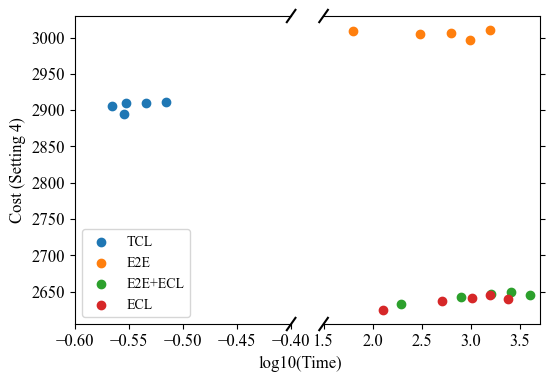

In [55]:
# 创建主图
fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,4))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 10

# 绘制 TCL 的散点图
ax.scatter(np.log10(total_time_with_N),Cost_with_N, label='TCL')
ax2.scatter(np.log10(total_time_with_N), Cost_with_N, label='TCL')

# 绘制 E2E 的散点图
ax.scatter(np.log10(total_time_with_N_e2e), Cost_with_N_e2e, label='E2E')
ax2.scatter(np.log10(total_time_with_N_e2e), Cost_with_N_e2e, label='E2E')

# 绘制 E2E+ECL 的散点图
ax.scatter(np.log10(total_time_with_N_e2e_ecl + total_time_with_N_e2e), Cost_with_N_e2e_ecl, label='E2E+ECL')
ax2.scatter(np.log10(total_time_with_N_e2e_ecl + total_time_with_N_e2e), Cost_with_N_e2e_ecl, label='E2E+ECL')

# 绘制 ECL 的散点图
ax.scatter(np.log10(total_time_with_N_online_e2e), Cost_with_N_online_e2e, label='ECL')
ax2.scatter(np.log10(total_time_with_N_online_e2e), Cost_with_N_online_e2e, label='ECL')

# 设置 x 轴范围
ax.set_xlim(-0.6, -0.4)
ax2.set_xlim(1.5, 3.7)

# 设置标题和标签
fig.text(0.5, 0, 'log10(Time)', ha='center',fontsize=12)

ax.set_ylabel('Cost (Setting '+str(int(2*args_train.flag_dynamic_price)+int(args_train.flag_dynamic_mode))+')',fontsize=12)

#ax.legend(loc='upper left')

# 去掉中间的空白
fig.subplots_adjust(wspace=0.15)
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax2.yaxis.tick_right()

# 添加断轴符号
d = .02  # 断轴符号的大小
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d, 1+d), (-d, +d), **kwargs)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax.legend(loc='lower left')
# 显示图形
#plt.title('The training time and operation Cost of different methods')
plt.savefig('../Figure/Time_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.png',dpi=300)
plt.show()

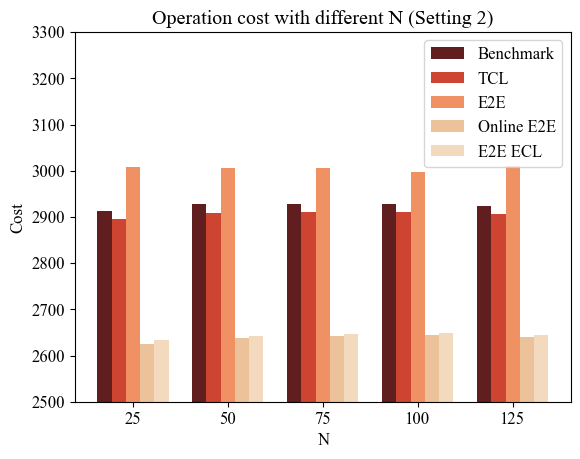

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cost_1=Cost_with_N_org
cost_2=Cost_with_N
cost_3=Cost_with_N_e2e
cost_4=Cost_with_N_online_e2e 
cost_5=Cost_with_N_e2e_ecl
plt.rcParams['font.size'] = 12
# color_1 = (64/255, 3/255, 126/255)
# color_2 = (91/255, 53/255, 149/255)
# color_3 = (121/255, 111/255, 179/255)
# color_4 = (156/255, 152/255, 199/255)
# color_5 = (197/255, 197/255, 224/255)
# color_5 = (229/255, 227/255, 240/255)

color_1 = (97/255, 30/255, 30/255)
color_2 = (205/255, 68/255, 50/255)
color_3 = (239/255, 145/255, 99/255)
color_4 = (236/255, 194/255, 155/255)
color_5 = (243/255, 217/255, 190/255)

# for epsion in [1000,100,10,1,1e-1,1e-2]:
#     print('epsion:',epsion)
#     cost_3.append(np.mean(vars()['cost_list_e2e'+str(epsion)]))
#     cost_1.append(np.mean(vars()['cost_org'+str(epsion)]))
#     cost_2.append(np.mean(vars()['cost_list'+str(epsion)]))
cost_2=np.array(cost_2)
cost_1=np.array(cost_1)
cost_3=np.array(cost_3)
cost_4=np.array(cost_4)
cost_5=np.array(cost_5)
epsions = [25,50,75,100,125]
fig, ax1 = plt.subplots()

bar_width = 0.15
indices = np.arange(len(epsions))

ax1.set_xlabel('N')
ax1.set_ylabel('Cost')

ax1.bar(indices -2* bar_width, cost_1, bar_width, label='Benchmark', color=color_1)

ax1.bar(indices- 1* bar_width, cost_2, bar_width, label='TCL', color=color_2)
#ax1.plot(indices- 1 * bar_width, cost_2, '-',  color=color_2)
ax1.bar(indices, cost_3, bar_width, label='E2E', color=color_3)
#ax1.plot(indices, cost_3, '-', color=color_3)

ax1.bar(indices + bar_width, cost_4, bar_width, label='Online E2E', color=color_4)
#ax1.plot(indices + bar_width, cost_4, '-', color=color_4)
ax1.bar(indices + 2 * bar_width, cost_5, bar_width, label='E2E ECL', color=color_5)
#ax1.plot(indices + 2 * bar_width, cost_5, '-', color=color_5)


ax1.legend(loc='upper left')

ax1.set_ylim(2500, 3300)

ax1.set_xticks(indices)
ax1.set_xticklabels(epsions)

ax1.legend(loc='upper right')
plt.title(r'Operation cost with different N '+'(Setting '+str(args_train.flag_dynamic_mode)+')')
plt.savefig('../Figure/Cost vs N non parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.png')

dic={'Benchmark':cost_1,'TCL':cost_2,'E2E':cost_3,'Online E2E':cost_4,'E2E ECL':cost_5}
df=pd.DataFrame(dic)
df.to_csv('../Result/Different N/Non parameter/Cost vs N non parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv')
plt.show()